In [14]:
import gymnasium as gym
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

50 / 2000 : -145.98, -29.14
100 / 2000 : 44.20, 44.20
150 / 2000 : -1.11, 56.11
200 / 2000 : 110.61, 110.61
250 / 2000 : 119.42, 119.42
300 / 2000 : 34.80, 119.42
350 / 2000 : -8.84, 119.42
400 / 2000 : 116.99, 119.42
450 / 2000 : 106.07, 119.42
500 / 2000 : 115.43, 140.32
550 / 2000 : 32.83, 153.37
600 / 2000 : 80.66, 161.23
650 / 2000 : 127.97, 171.91
700 / 2000 : 32.63, 171.91
750 / 2000 : 151.09, 171.91
800 / 2000 : 128.70, 171.91
850 / 2000 : 157.93, 171.91
900 / 2000 : 89.06, 171.91
950 / 2000 : 110.25, 176.45
1000 / 2000 : 146.35, 176.45
1050 / 2000 : 118.44, 176.45
1100 / 2000 : 82.14, 176.45
1150 / 2000 : 97.83, 176.45
1200 / 2000 : 69.75, 176.45
1250 / 2000 : 63.72, 176.45
1300 / 2000 : 66.95, 176.45
1350 / 2000 : 5.18, 176.45
1400 / 2000 : 72.02, 176.45
1450 / 2000 : 68.82, 176.45
1500 / 2000 : 76.93, 176.45
1550 / 2000 : 132.87, 176.45
1600 / 2000 : 90.93, 176.45
1650 / 2000 : 83.02, 176.45
1700 / 2000 : 120.12, 176.45
1750 / 2000 : 70.13, 176.45
1800 / 2000 : 82.22, 176.45

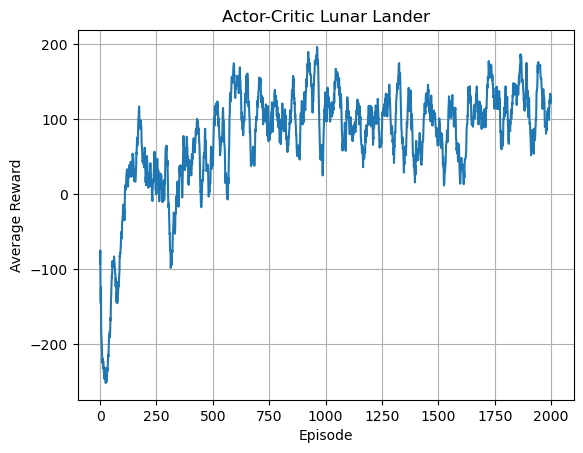

In [39]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.softmax(x, dim = -1)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

actor = Actor()
critic = Critic()

actor_optim = optim.Adam(actor.parameters(), lr = 3e-4)
critic_optim = optim.Adam(critic.parameters(), lr = 1e-3)

num_epochs = 2000
gamma = 0.999

env = gym.make('LunarLander-v3', continuous = False)


def get_action(state):
    state = torch.tensor(state, dtype = torch.float32)
    action_probs = actor(state)
    action = torch.distributions.Categorical(action_probs).sample()
    return action.item()

@torch.no_grad
def test(num_tests):
    tot_reward = 0
    for _ in range(0,num_tests):
        state, _ = env.reset()
        with torch.no_grad():
            while True:
                state = torch.tensor(state, dtype = torch.float32)
                action_probs = actor(state)
                action = torch.distributions.Categorical(action_probs).sample().item()
                state, reward, truncated, terminated, _ = env.step(action)
                tot_reward += reward
                if truncated or terminated:
                    break
    return tot_reward/num_tests

rewards = []
max_reward = -300
for epoch in range(1,num_epochs+1):
    state, _ = env.reset()
    I = 1
    tot_reward = 0
    while True:
        state = torch.tensor(state, dtype = torch.float32)
        action_probs = actor(state)
        action = torch.distributions.Categorical(action_probs).sample().item()
        next_state, reward, truncated, terminated, _ = env.step(action)
        tot_reward += reward
        cur_state_val = critic(state)

        if truncated or terminated:
            next_state_val = 0
        else:
            next_state_val = critic(next_state)

        td_target = reward + gamma * next_state_val - cur_state_val
        critic_loss = td_target ** 2
        actor_loss = -1 * td_target.detach() * I * torch.log(action_probs[action])

        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()

        if terminated or truncated:
            rewards.append(tot_reward)
            break

        state = next_state
        I *= gamma

    if epoch % 50 == 0:
        avg = test(50)
        if avg > max_reward:
            torch.save(actor.state_dict(), "LunarLanderAgent2.pt")
            max_reward = avg
        print(f"{epoch} / {num_epochs} : {avg:.2f}, {max_reward:.2f}")

    if np.mean(rewards[max(0,epoch-10):epoch]) > max_reward and epoch > 10:
        avg = test(50)
        if avg > max_reward:
            torch.save(actor.state_dict(), "LunarLanderAgent2.pt")
            max_reward = avg

    
    if epoch == 1000:
        actor_optim = optim.Adam(actor.parameters(), lr = 1e-4)
        critic_optim = optim.Adam(critic.parameters(), lr = 3e-4)

window = 20
avg_rewards = [np.mean(rewards[max(0,i-window):(i+1)]) for i in range(len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Actor-Critic Lunar Lander")
plt.grid()
plt.show()

In [38]:
env = gym.make('LunarLander-v3')
state, _ = env.reset()
actor_temp = Actor()
actor_temp.load_state_dict(torch.load("LunarLanderAgent.pt", weights_only=True))
tot_reward = 0
for i in range(0,1000):
    state, _ = env.reset()
    while True:
        state = torch.tensor(state, dtype = torch.float32)
        action_probs = actor_temp(state)
        action = torch.distributions.Categorical(action_probs).sample().item()
        state, reward, truncated, terminated, _ = env.step(action)
        tot_reward += reward
        if truncated or terminated:
            break
print(tot_reward/1000)

205.03806739475166
